In [1]:
# set work dir
import os
os.chdir("../pkg")

In [2]:
import time
import copy
import pyepo
import torch
from torch import nn
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
plt.style.reload_library()
plt.style.use("science")
from matplotlib import ticker
import tol_colors as tc
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)
from sklearn.model_selection import train_test_split

Auto-Sklearn cannot be imported.


In [3]:
# linear model
class LinearRegression(nn.Module):
    
    def __init__(self, indim, outdim):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(indim, outdim)
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [4]:
def train_h(optmodel, reg, trainloader, testloader, lr, num_epochs=300, lambd=20):
    # cuda
    if torch.cuda.is_available():
        reg = reg.cuda()
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set dbb optimizer
    dbb = pyepo.func.blackboxOpt(optmodel, lambd=lambd, processes=4)
    # set loss
    criterion = nn.L1Loss()
    # train model
    reg.train()
    loss_log = []
    grad_log = []
    trueloss = pyepo.metric.regret(reg, optmodel, testloader)
    loss_log_truespo = [trueloss]
    print("Epoch   0, Loss: Unknown, Regret: {:7.4f}%".format(trueloss*100))
    for epoch in range(num_epochs):
        # load data
        for i, data in enumerate(trainloader):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # linear regression
            cp = reg(x)
            # black-box optimizer
            wp = dbb(cp)
            # loss
            loss = criterion(wp, w)
            # add hook
            abs_grad = []
            cp.register_hook(lambda grad: abs_grad.append(torch.abs(grad).mean().item()))
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_log.append(loss.item())
        grad_log.append(abs_grad[0])
        if (epoch + 1) % 5 == 0:
            # true SPO
            trueloss = pyepo.metric.regret(reg, optmodel, testloader)
            loss_log_truespo.append(trueloss)
            print("Epoch {:3}, Loss: {:7.4f}, Regret: {:7.4f}%".format(epoch+1, loss.item(), trueloss*100))
    drawplot(num_epochs, grad_log, loss_log)
    return loss_log_truespo

In [5]:
def train_r(optmodel, reg, trainloader, testloader, lr, num_epochs=300, lambd=20):
    # cuda
    if torch.cuda.is_available():
        reg = reg.cuda()
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set dbb optimizer
    dbb = pyepo.func.blackboxOpt(optmodel, lambd=lambd, processes=4)
    # set loss
    criterion = nn.L1Loss()
    # train model
    reg.train()
    trueloss = pyepo.metric.regret(reg, optmodel, testloader)
    loss_log_truespo = [trueloss]
    print("Epoch   0, Loss: Unknown, Regret: {:7.4f}%".format(trueloss*100))
    for epoch in range(num_epochs):
        # load data
        for i, data in enumerate(trainloader):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # linear regression
            cp = reg(x)
            # black-box optimizer
            wp = dbb(cp)
            # objective value
            zp = (wp * c).sum(1).view(-1, 1)
            # loss
            loss = criterion(zp, z)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 5 == 0:
            # true SPO
            trueloss = pyepo.metric.regret(reg, optmodel, testloader)
            loss_log_truespo.append(trueloss)
            print("Epoch {:3}, Loss: {:7.4f}, Regret: {:7.4f}%".format(epoch+1, loss.item(), trueloss*100))
    return loss_log_truespo

In [6]:
def drawplot(num_epochs, grad_log, loss_log):
    # loss
    fig = plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=3)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Learning Curve", fontsize=36)
    plt.show()
    # abs grad
    fig = plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="c", lw=3)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Learning Curve", fontsize=36)
    plt.show()

## Shortest Path

In [7]:
# init data
grid = (5,5) # grid graph
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise half-width
x, c = pyepo.data.shortestpath.genData(n+1000, p, grid, deg=deg, noise_width=e)

In [8]:
# optimization model 
sp_model = pyepo.model.grb.shortestPathModel(grid)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-05


In [9]:
# prediction model
reg = LinearRegression(p, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

In [10]:
# dataset
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)
sp_dataset_train = pyepo.data.dataset.optDataset(sp_model, x_train, c_train)
sp_dataset_test = pyepo.data.dataset.optDataset(sp_model, x_test, c_test)
# data loader
batch_size = 32
sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1063.60it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1054.62it/s]


Num of cores: 4
Epoch   0, Loss: Unknown, Regret: 52.0637%
Epoch   5, Loss:  0.2188, Regret: 34.8523%
Epoch  10, Loss:  0.2875, Regret: 27.6626%
Epoch  15, Loss:  0.1625, Regret: 19.7933%
Epoch  20, Loss:  0.0938, Regret: 18.1883%
Epoch  25, Loss:  0.1313, Regret: 15.7747%
Epoch  30, Loss:  0.1875, Regret: 13.5473%
Epoch  35, Loss:  0.1437, Regret: 11.8066%
Epoch  40, Loss:  0.2250, Regret: 11.8322%
Epoch  45, Loss:  0.0938, Regret: 11.6203%
Epoch  50, Loss:  0.1250, Regret: 11.5789%
Epoch  55, Loss:  0.1500, Regret: 11.0437%
Epoch  60, Loss:  0.1875, Regret: 10.6071%
Epoch  65, Loss:  0.1500, Regret: 11.0030%
Epoch  70, Loss:  0.1562, Regret: 11.4039%
Epoch  75, Loss:  0.0813, Regret: 10.8031%
Epoch  80, Loss:  0.2000, Regret: 10.4186%
Epoch  85, Loss:  0.1625, Regret: 11.2244%
Epoch  90, Loss:  0.1625, Regret: 11.5469%
Epoch  95, Loss:  0.1063, Regret: 11.6613%
Epoch 100, Loss:  0.1313, Regret: 11.3166%
Epoch 105, Loss:  0.1000, Regret: 10.5140%
Epoch 110, Loss:  0.1437, Regret: 10.7

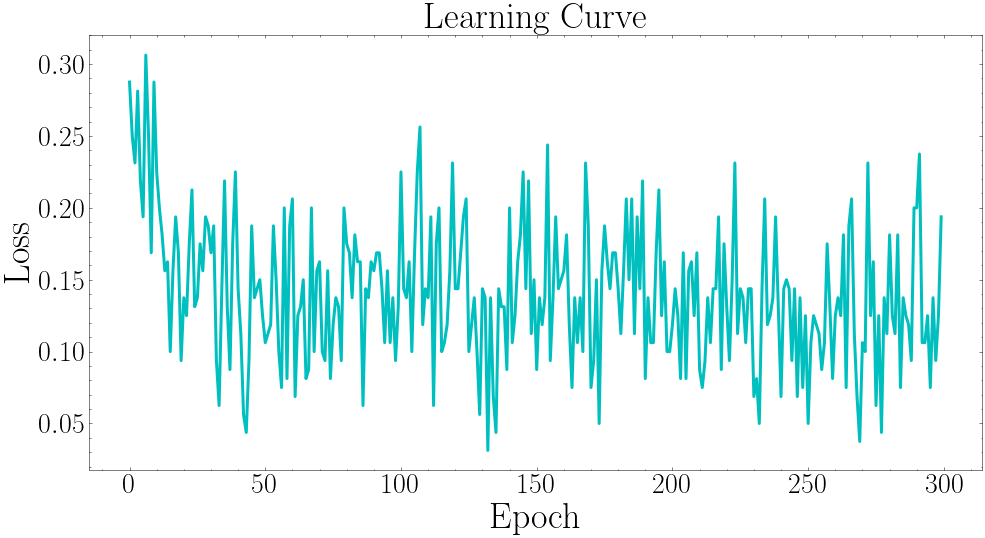

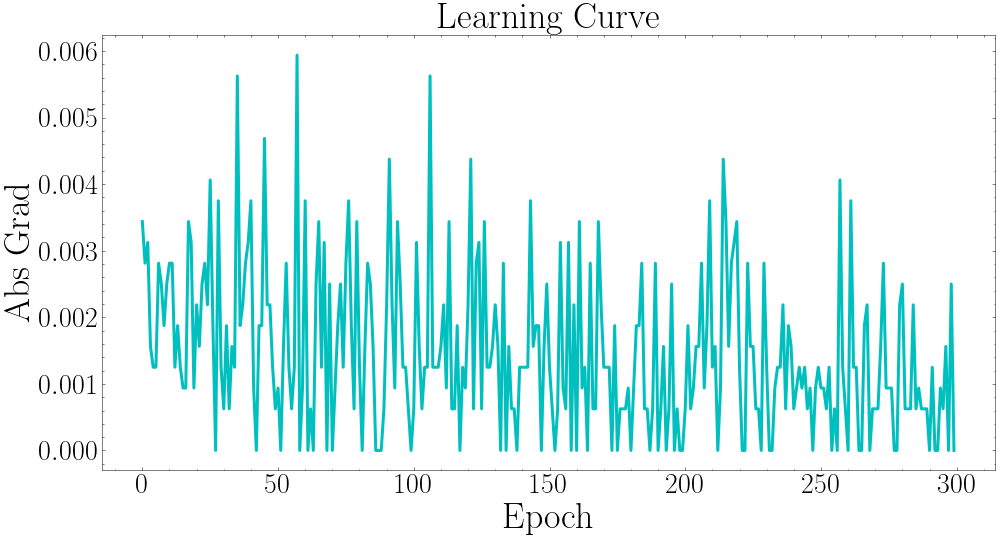

In [11]:
# train
loss_h = train_h(sp_model, copy.deepcopy(reg), sp_loader_train, sp_loader_test, lr=5e-3)

In [12]:
# train
loss_r = train_r(sp_model, copy.deepcopy(reg), sp_loader_train, sp_loader_test, lr=5e-3)

Num of cores: 4
Epoch   0, Loss: Unknown, Regret: 52.0637%
Epoch   5, Loss:  0.6238, Regret: 12.8398%
Epoch  10, Loss:  0.2643, Regret: 15.1449%
Epoch  15, Loss:  0.3815, Regret: 14.5534%
Epoch  20, Loss:  0.6513, Regret: 13.1257%
Epoch  25, Loss:  0.5451, Regret: 16.7001%
Epoch  30, Loss:  0.3268, Regret: 21.9680%
Epoch  35, Loss:  0.5837, Regret: 19.7577%
Epoch  40, Loss:  0.4307, Regret: 16.3088%
Epoch  45, Loss:  0.6949, Regret: 18.9445%
Epoch  50, Loss:  0.3409, Regret: 19.4224%
Epoch  55, Loss:  0.4634, Regret: 18.7002%
Epoch  60, Loss:  0.7121, Regret: 14.5704%
Epoch  65, Loss:  0.3572, Regret: 14.0131%
Epoch  70, Loss:  0.4706, Regret: 21.0732%
Epoch  75, Loss:  0.5163, Regret: 16.9266%
Epoch  80, Loss:  0.5958, Regret: 15.3373%
Epoch  85, Loss:  0.4263, Regret: 18.5164%
Epoch  90, Loss:  0.6195, Regret: 19.1176%
Epoch  95, Loss:  0.3189, Regret: 15.9592%
Epoch 100, Loss:  1.2028, Regret: 18.7518%
Epoch 105, Loss:  0.4769, Regret: 18.0511%
Epoch 110, Loss:  0.7164, Regret: 17.0

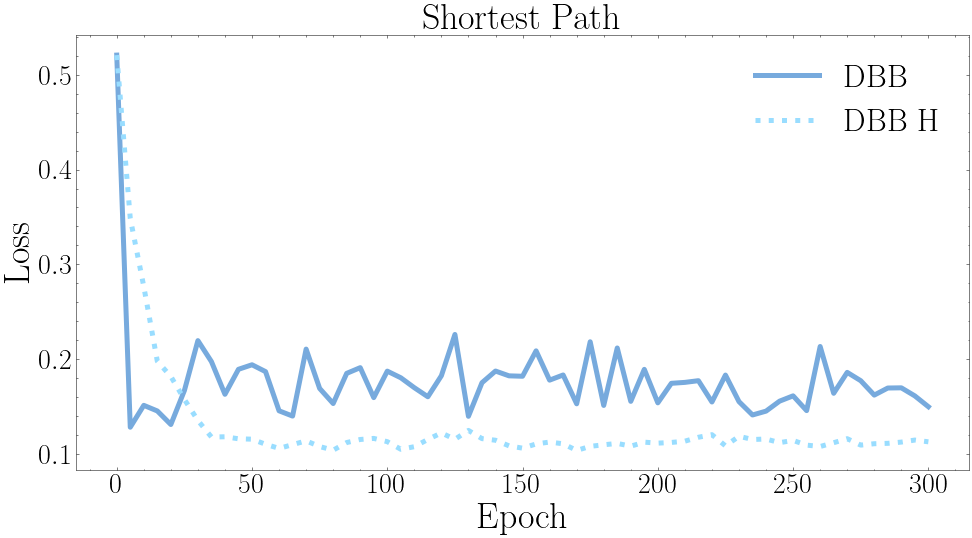

In [13]:
# color map
cset =  tc.tol_cset('light')
colors = [cset.light_blue, cset.light_cyan]
# draw plot
fig = plt.figure(figsize=(16, 8))
plt.plot(range(0, 305, 5), loss_r, color=cset.light_blue, ls="-", lw=5, label="DBB")
plt.plot(range(0, 305, 5), loss_h, color=cset.light_cyan, ls=":", lw=5, label="DBB H")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Shortest Path", fontsize=36)
plt.legend(fontsize=32)
plt.show()
fig.savefig("./images/hamming-sp.pdf", dpi=300)

## 2D Knapsack

In [14]:
# init data
m = 48 # number of items
n = 100 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
dim = 2 # dimension of knapsack
noise_width = 0.5 # noise half-width
caps = [30] * dim # capacity
weights, x, c = pyepo.data.knapsack.genData(n+1000, p, m, deg=deg, dim=dim, noise_width=noise_width)

In [15]:
# optimization model 
ks_model = pyepo.model.grb.knapsackModel(weights, caps)

In [16]:
# prediction model
reg = LinearRegression(p, m)

In [17]:
# dataset
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)
ks_dataset_train = pyepo.data.dataset.optDataset(ks_model, x_train, c_train)
ks_dataset_test = pyepo.data.dataset.optDataset(ks_model, x_test, c_test)
# data loader
batch_size = 32
ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 345.94it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 330.29it/s]


Num of cores: 4
Epoch   0, Loss: Unknown, Regret: 52.6396%
Epoch   5, Loss:  0.1979, Regret: 52.6396%
Epoch  10, Loss:  0.2083, Regret: 52.6396%
Epoch  15, Loss:  0.1823, Regret: 52.6396%
Epoch  20, Loss:  0.2031, Regret: 52.6396%
Epoch  25, Loss:  0.2188, Regret: 52.6396%
Epoch  30, Loss:  0.1979, Regret: 52.6396%
Epoch  35, Loss:  0.1719, Regret: 52.6396%
Epoch  40, Loss:  0.2083, Regret: 52.6396%
Epoch  45, Loss:  0.2240, Regret: 52.6396%
Epoch  50, Loss:  0.2135, Regret: 52.6396%
Epoch  55, Loss:  0.2083, Regret: 52.6396%
Epoch  60, Loss:  0.1823, Regret: 52.6396%
Epoch  65, Loss:  0.2344, Regret: 52.6396%
Epoch  70, Loss:  0.2083, Regret: 52.6396%
Epoch  75, Loss:  0.2135, Regret: 52.6396%
Epoch  80, Loss:  0.2344, Regret: 52.6396%
Epoch  85, Loss:  0.2240, Regret: 52.6396%
Epoch  90, Loss:  0.1979, Regret: 52.6396%
Epoch  95, Loss:  0.2188, Regret: 52.6396%
Epoch 100, Loss:  0.2083, Regret: 52.6396%
Epoch 105, Loss:  0.2031, Regret: 52.6396%
Epoch 110, Loss:  0.2031, Regret: 52.6

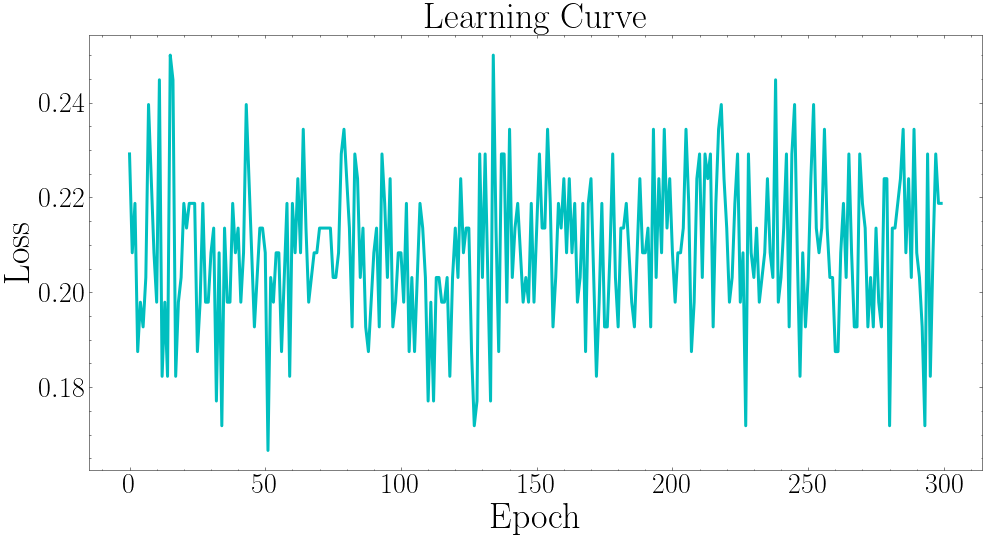

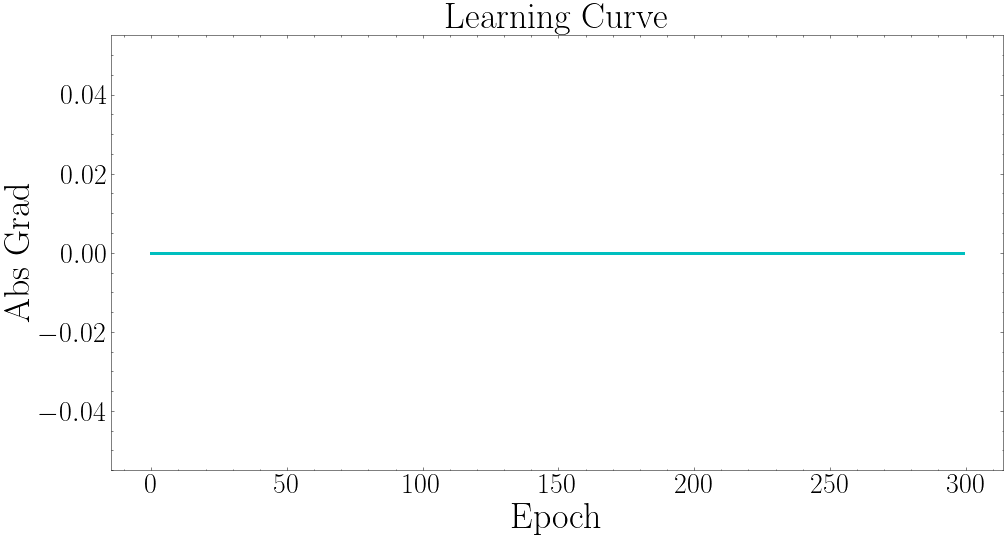

In [18]:
# train
loss_h = train_h(ks_model, copy.deepcopy(reg), ks_loader_train, ks_loader_test, lr=5e-2)

In [19]:
# train
loss_r = train_r(ks_model, copy.deepcopy(reg), ks_loader_train, ks_loader_test, lr=5e-2)

Num of cores: 4
Epoch   0, Loss: Unknown, Regret: 52.6396%
Epoch   5, Loss: 41.5000, Regret: 39.6287%
Epoch  10, Loss: 20.7500, Regret: 32.7394%
Epoch  15, Loss: 18.0000, Regret: 27.8340%
Epoch  20, Loss: 22.7500, Regret: 25.0742%
Epoch  25, Loss: 13.7500, Regret: 23.2681%
Epoch  30, Loss:  4.0000, Regret: 22.2438%
Epoch  35, Loss:  3.7500, Regret: 21.0801%
Epoch  40, Loss: 13.2500, Regret: 20.1366%
Epoch  45, Loss: 10.5000, Regret: 19.3103%
Epoch  50, Loss:  5.5000, Regret: 18.5021%
Epoch  55, Loss:  5.7500, Regret: 17.9385%
Epoch  60, Loss:  2.7500, Regret: 17.7748%
Epoch  65, Loss:  4.0000, Regret: 17.5849%
Epoch  70, Loss:  7.2500, Regret: 17.3202%
Epoch  75, Loss: 14.7500, Regret: 17.3344%
Epoch  80, Loss:  2.0000, Regret: 17.3384%
Epoch  85, Loss: 20.2500, Regret: 17.3364%
Epoch  90, Loss:  7.2500, Regret: 17.4374%
Epoch  95, Loss: 10.0000, Regret: 17.4475%
Epoch 100, Loss:  7.7500, Regret: 17.3707%
Epoch 105, Loss:  5.7500, Regret: 17.3202%
Epoch 110, Loss:  5.2500, Regret: 17.2

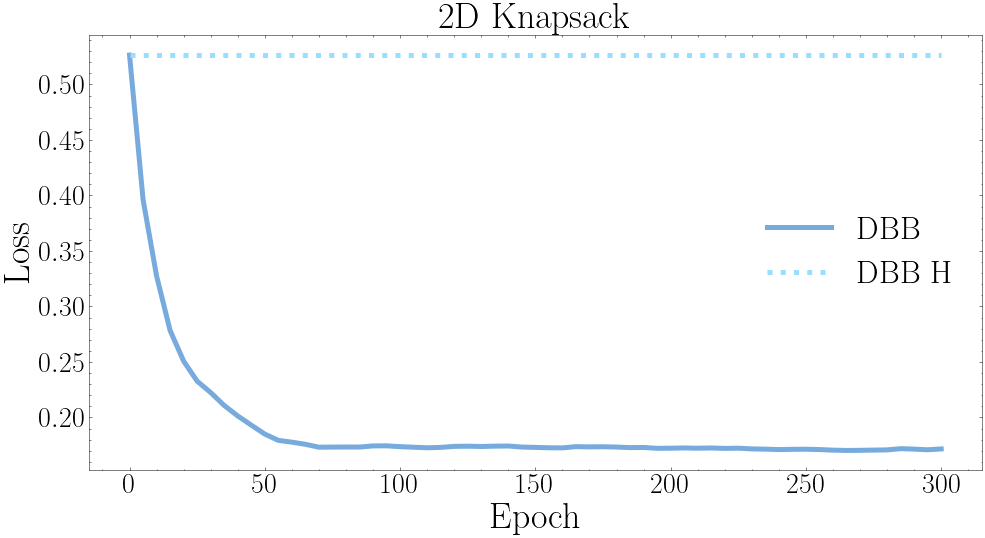

In [20]:
# color map
cset =  tc.tol_cset('light')
colors = [cset.light_blue, cset.light_cyan]
# draw plot
fig = plt.figure(figsize=(16, 8))
plt.plot(range(0, 305, 5), loss_r, color=cset.light_blue, ls="-", lw=5, label="DBB")
plt.plot(range(0, 305, 5), loss_h, color=cset.light_cyan, ls=":", lw=5, label="DBB H")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("2D Knapsack", fontsize=36)
plt.legend(fontsize=32)
plt.show()
fig.savefig("./images/hamming-ks2.pdf", dpi=300)

## TSP 

In [21]:
# init data
m = 20 # number of nodes
n = 1000 # number of data
p = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise half-width
x, c = pyepo.data.tsp.genData(n+1000, p, m, deg=deg, noise_width=e)

In [22]:
# optimization model 
tsp_model = pyepo.model.grb.tspDFJModel(m)

In [23]:
# prediction model
reg = LinearRegression(p, m*(m-1)//2)

In [24]:
# dataset
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=600, random_state=246)
tsp_dataset_train = pyepo.data.dataset.optDataset(tsp_model, x_train, c_train)
tsp_dataset_test = pyepo.data.dataset.optDataset(tsp_model, x_test, c_test)
# data loader
batch_size = 32
tsp_loader_train = DataLoader(tsp_dataset_train, batch_size=batch_size, shuffle=True)
tsp_loader_test = DataLoader(tsp_dataset_test, batch_size=batch_size, shuffle=False)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1400/1400 [00:09<00:00, 145.74it/s]


Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:04<00:00, 144.27it/s]


Num of cores: 4
Epoch   0, Loss: Unknown, Regret: 181.6178%
Epoch   5, Loss:  0.1781, Regret: 148.9488%
Epoch  10, Loss:  0.1811, Regret: 148.1333%
Epoch  15, Loss:  0.1737, Regret: 147.6122%
Epoch  20, Loss:  0.1728, Regret: 138.4284%
Epoch  25, Loss:  0.1719, Regret: 137.6543%
Epoch  30, Loss:  0.1728, Regret: 137.0438%
Epoch  35, Loss:  0.1711, Regret: 137.0650%
Epoch  40, Loss:  0.1759, Regret: 137.6129%
Epoch  45, Loss:  0.1737, Regret: 136.3540%
Epoch  50, Loss:  0.1737, Regret: 137.6751%
Epoch  55, Loss:  0.1711, Regret: 139.5554%
Epoch  60, Loss:  0.1746, Regret: 135.7095%
Epoch  65, Loss:  0.1724, Regret: 143.9401%
Epoch  70, Loss:  0.1702, Regret: 140.6643%
Epoch  75, Loss:  0.1741, Regret: 139.2619%
Epoch  80, Loss:  0.1728, Regret: 138.4872%
Epoch  85, Loss:  0.1754, Regret: 142.1379%
Epoch  90, Loss:  0.1772, Regret: 140.7692%
Epoch  95, Loss:  0.1715, Regret: 142.0471%
Epoch 100, Loss:  0.1719, Regret: 142.8304%
Epoch 105, Loss:  0.1702, Regret: 143.8072%
Epoch 110, Loss:

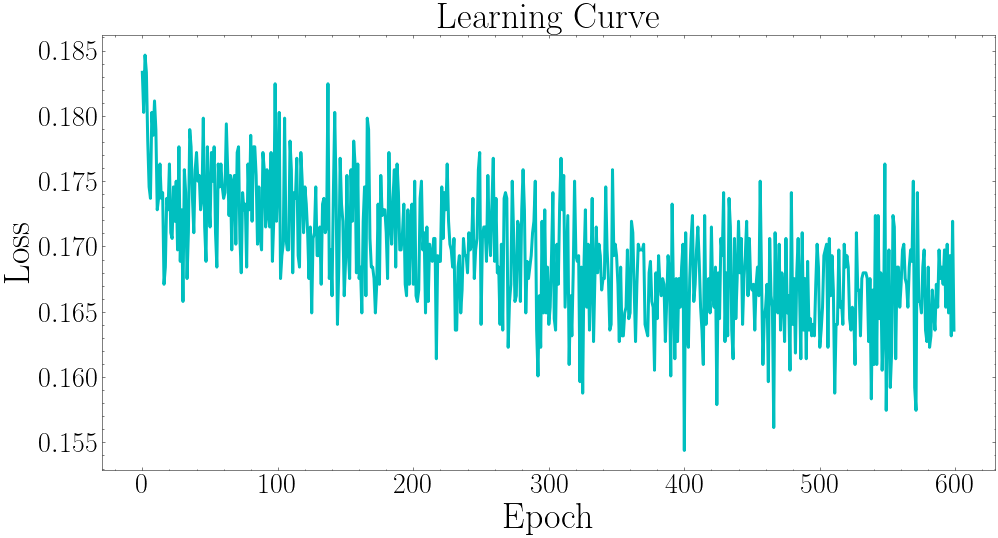

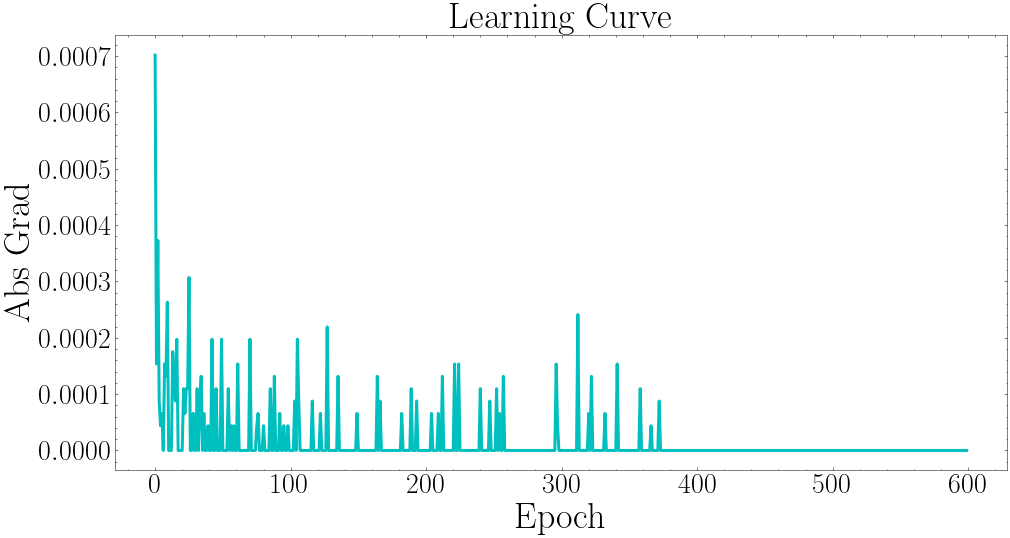

In [25]:
# train
loss_h = train_h(tsp_model, copy.deepcopy(reg), tsp_loader_train, tsp_loader_test, num_epochs=600, lr=5e-2)

In [26]:
# train
loss_r = train_r(tsp_model, copy.deepcopy(reg), tsp_loader_train, tsp_loader_test, lr=5e-2)

Num of cores: 4
Epoch   0, Loss: Unknown, Regret: 181.6178%
Epoch   5, Loss:  4.8860, Regret:  9.0941%
Epoch  10, Loss:  3.9792, Regret:  8.5680%
Epoch  15, Loss:  3.1844, Regret:  8.1460%
Epoch  20, Loss:  3.1146, Regret:  7.7654%
Epoch  25, Loss:  3.0627, Regret:  7.6520%
Epoch  30, Loss:  2.8263, Regret:  8.0608%
Epoch  35, Loss:  2.5675, Regret:  7.4965%
Epoch  40, Loss:  3.0542, Regret:  7.7859%
Epoch  45, Loss:  3.3858, Regret:  7.8269%
Epoch  50, Loss:  2.6272, Regret:  7.3284%
Epoch  55, Loss:  3.3939, Regret:  7.3978%
Epoch  60, Loss:  2.3941, Regret:  7.4104%
Epoch  65, Loss:  2.2285, Regret:  7.3791%
Epoch  70, Loss:  2.5891, Regret:  6.9211%
Epoch  75, Loss:  2.2641, Regret:  7.0657%
Epoch  80, Loss:  2.9215, Regret:  7.1356%
Epoch  85, Loss:  3.1018, Regret:  7.1011%
Epoch  90, Loss:  2.0528, Regret:  6.8765%
Epoch  95, Loss:  3.1825, Regret:  7.3459%
Epoch 100, Loss:  3.2473, Regret:  7.0519%
Epoch 105, Loss:  2.5204, Regret:  7.2183%
Epoch 110, Loss:  3.0607, Regret:  7.

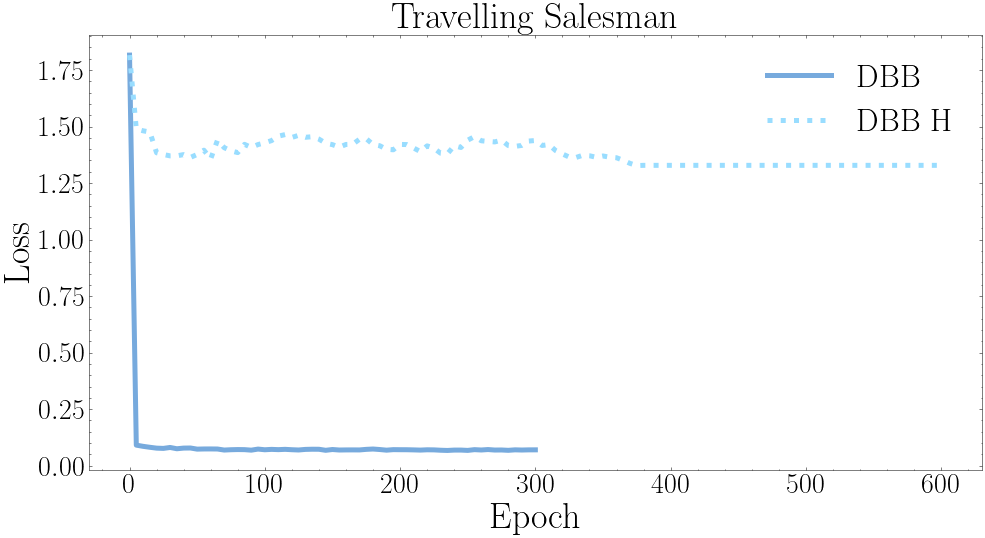

In [27]:
# color map
cset =  tc.tol_cset('light')
colors = [cset.light_blue, cset.light_cyan]
# draw plot
fig = plt.figure(figsize=(16, 8))
plt.plot(range(0, 305, 5), loss_r, color=cset.light_blue, ls="-", lw=5, label="DBB")
plt.plot(range(0, 605, 5), loss_h, color=cset.light_cyan, ls=":", lw=5, label="DBB H")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Travelling Salesman", fontsize=36)
plt.legend(fontsize=32)
plt.show()
fig.savefig("./images/hamming-tsp.pdf", dpi=300)